In [343]:
import torch
from torch import nn 
import numpy as np
import gym
import matplotlib.pyplot as plt
from torch.utils.tensorboard import SummaryWriter
import json
from matplotlib import animation
import matplotlib.patches as patches
%matplotlib inline

In [2]:
class CEM(nn.Module):
    def __init__(self, state_dim, action_n):
        super().__init__()
        self.device = torch.device('cuda')
        self.state_dim = state_dim
        self.action_n = action_n
        
        self.network = nn.Sequential(
            nn.Linear(self.state_dim, 32), 
            nn.ReLU(), 
            nn.Linear(32, 32), 
            nn.ReLU(), 
            nn.Linear(32, self.action_n)
        )
        #self.network.to(self.device)
        
        self.softmax = nn.Softmax()
        self.optimizer = torch.optim.Adam(self.parameters(), lr=0.012)
        self.loss = nn.CrossEntropyLoss()
        
    def forward(self, _input):
        #_input = _input.to(self.device)
        return self.network(_input)
    
    def get_action(self, state, exploration=0):
        state = torch.FloatTensor(state)
        #logits = self.forward(state).to('cpu')
        logits = self.forward(state)
        action_prob = self.softmax(logits).detach().numpy()
        p=(1-exploration)*action_prob+exploration*np.ones(self.action_n)/self.action_n
        if(exploration < 0):
            action = np.argmax(action_prob)
        else:
            action = np.random.choice(self.action_n, p=p/p.sum())
        return action
    
    def update_policy(self, elite_trajectories):
        elite_states = []
        elite_actions = []
        for trajectory in elite_trajectories:
            elite_states.extend(trajectory['states'])
            elite_actions.extend(trajectory['actions'])
        elite_states = torch.FloatTensor(np.array(elite_states))
        #elite_states = elite_states.to(self.device)
        elite_actions = torch.LongTensor(np.array(elite_actions))
        #elite_actions = elite_actions.to(self.device)
        self.optimizer.zero_grad()
        loss = self.loss(self.forward(elite_states), elite_actions)
        loss.backward()
        self.optimizer.step()
        
def get_trajectory(env, agent, trajectory_len, exploration=0, visualize=False):
    trajectory = {'states':[], 'actions': [], 'total_reward': 0}
    
    state = env.reset()
    trajectory['states'].append(state)
    for i in range(trajectory_len):
        with torch.no_grad():
            action = agent.get_action(state, exploration)
        trajectory['actions'].append(action)
        
        state, reward, done, _ = env.step(action)
        trajectory['total_reward'] += reward
        
        if done:
            break
            
        if visualize:
            env.render()
        
        if(i != trajectory_len-1):
            trajectory['states'].append(state)
    
    if visualize:
        print(i,trajectory['total_reward'])  
    return trajectory

def get_elite_trajectories(trajectories, q_param, solved_traj):
    total_rewards = [trajectory['total_reward'] for trajectory in trajectories]
    quantile = np.quantile(total_rewards, q=q_param)
    new_solved = [trajectory for trajectory in trajectories if trajectory['total_reward'] >= 200]
    if(len(new_solved)):
        solved_traj.extend(new_solved)
        pass
    return [trajectory for trajectory in trajectories if trajectory['total_reward'] >= quantile]


In [3]:
"""
Ensure you have imagemagick installed with 
sudo apt-get install imagemagick
Open file in CLI with:
xgd-open <filelname>
"""
def save_frames_as_gif(frames, path='./', filename='gym_animation.gif'):

    #Mess with this to change frame size
    plt.figure(figsize=(frames[0].shape[1] / 72.0, frames[0].shape[0] / 72.0), dpi=80)

    patch = plt.imshow(frames[0])
    plt.axis('off')

    def animate(i):
        patch.set_data(frames[i])

    anim = animation.FuncAnimation(plt.gcf(), animate, frames = len(frames), interval=20)
    anim.save(path + filename, writer='imagemagick', fps=50)


In [347]:
env = gym.make('LunarLander-v2')
state_dim = 8
action_n = 4
agent = CEM(state_dim, action_n)
agent.load_state_dict(torch.load('luna3232_best.model'))
agent.eval()

CEM(
  (network): Sequential(
    (0): Linear(in_features=8, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=4, bias=True)
  )
  (softmax): Softmax(dim=None)
  (loss): CrossEntropyLoss()
)

In [348]:
#Run the env
observation = env.reset()
frames = []
obs = []
t = 1
for i in range(400*4):
    #Render to frames buffer
    frames.append(env.render(mode="rgb_array"))
    action = agent.get_action(observation, -1)
    observation, _, done, _ = env.step(action)
    obs.append(observation)
    if done:
        t-=1
        print(t)
        if t<=0:
            print('end')
            break
        observation = env.reset()
env.close()
save_frames_as_gif(frames)
obs = (np.array(obs))

C:\Users\boh-b\AppData\Local\Temp\ipykernel_13556\1737028351.py:29: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  action_prob = self.softmax(logits).detach().numpy()


0
end


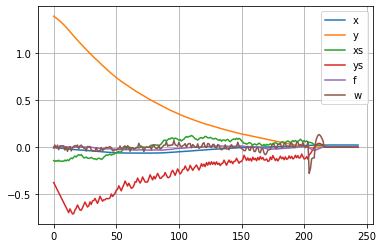

In [349]:
plt.plot(obs[:,:6])
plt.legend(['x','y','xs','ys','f','w'])
plt.grid(True)

In [247]:
agent.softmax(agent.forward(torch.FloatTensor(obs[1:3,:])))

C:\Users\boh-b\AppData\Local\Temp\ipykernel_13556\418207008.py:1: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  agent.softmax(agent.forward(torch.FloatTensor(obs[1:3,:])))


tensor([[0.0558, 0.0174, 0.0426, 0.8842],
        [0.0555, 0.0171, 0.0425, 0.8849]], grad_fn=<SoftmaxBackward0>)

In [354]:
pic = np.zeros((300,300,3))
pic_w = np.zeros((300,300,3))
obs = np.zeros((300*300,8))
vx = 0.4
vy = 0
f = 0
w = 0
l = 0
r = 0
for x in range(300):
    for y in range(300):
        obs[x*300+y] = np.array([-1.5+x/100,1.5-y/100,vx,vy,f,w,l,r])
act_flat = agent.softmax(agent.forward(torch.FloatTensor(obs))).detach().numpy()
actions = np.zeros((300,300,4))
for x in range(300):
    for y in range(300):
        actions[x,y,:] = act_flat[x*300+y,:]


C:\Users\boh-b\AppData\Local\Temp\ipykernel_13556\1128401417.py:13: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  act_flat = agent.softmax(agent.forward(torch.FloatTensor(obs))).detach().numpy()


In [355]:
max_actions = actions.argmax(2)
for x in range(300):
    for y in range(300):
        if True:
            pic[x,y,:] = actions[x,y,1:]

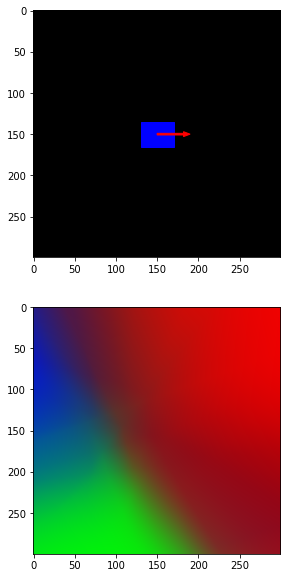

In [356]:
fig = plt.figure(figsize=(5,10))
ax = plt.subplot(211)
ax.imshow(pic_w)
rect = patches.Rectangle((150-20, 150-15), 40, 30, angle=-f/3.14*180, linewidth=1, edgecolor='b', facecolor='b')
arrow = patches.Arrow(150, 150,vx*100,-vy*100, width=10,  edgecolor='red', facecolor='r')
ax.add_patch(rect)
ax.add_patch(arrow)
plt.subplot(212)
plt.imshow(pic.transpose(1,0,2))
plt.savefig(f'lunalender_vx{vx}_vy{vy}_f{f}.png',dpi=300, bbox_inches='tight',facecolor='white')

In [360]:
def picc(vx=0,vy=0,f=0,w=0,l=0,r=0):
    pic = np.zeros((300,300,3))
    pic_w = np.zeros((300,300,3))
    obs = np.zeros((300*300,8))
    for x in range(300):
        for y in range(300):
            obs[x*300+y] = np.array([-1.5+x/100,1.5-y/100,vx,vy,f,w,l,r])
    act_flat = agent.softmax(agent.forward(torch.FloatTensor(obs))).detach().numpy()
    actions = np.zeros((300,300,4))
    for x in range(300):
        for y in range(300):
            actions[x,y,:] = act_flat[x*300+y,:]
            
    max_actions = actions.argmax(2)
    for x in range(300):
        for y in range(300):
            if max_actions[x,y]>0:
                pic[x,y,max_actions[x,y]-1] = 1
                
    fig = plt.figure(figsize=(5,10))
    ax = plt.subplot(211)
    ax.imshow(pic_w)
    rect = patches.Rectangle((150-20, 150-15), 40, 30, angle=-f/3.14*180, linewidth=1, edgecolor='b', facecolor='b')
    arrow = patches.Arrow(150, 150,vx*100,-vy*100, width=10,  edgecolor='red', facecolor='r')
    ax.add_patch(rect)
    ax.add_patch(arrow)
    plt.subplot(212)
    plt.imshow(pic.transpose(1,0,2))
    plt.savefig(f'visual/lunalender_vx{vx}_vy{vy}_f{f}.png',dpi=300, bbox_inches='tight',facecolor='white')

C:\Users\boh-b\AppData\Local\Temp\ipykernel_13556\3395478928.py:8: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  act_flat = agent.softmax(agent.forward(torch.FloatTensor(obs))).detach().numpy()


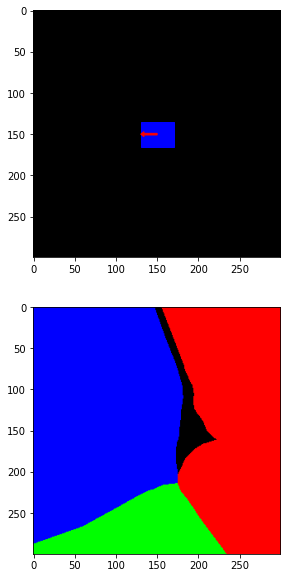

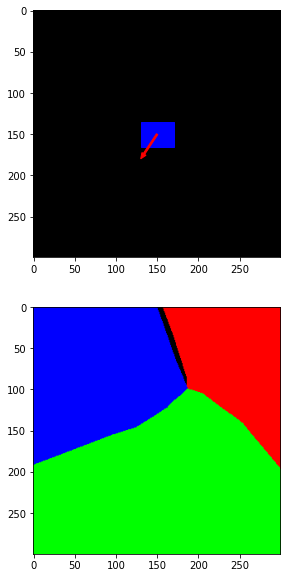

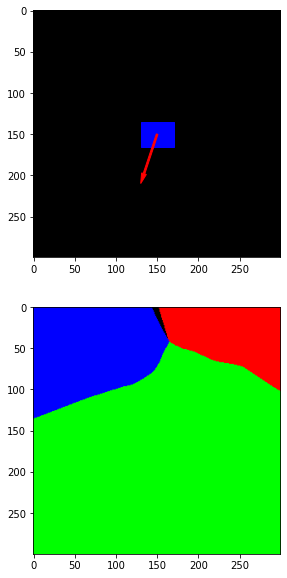

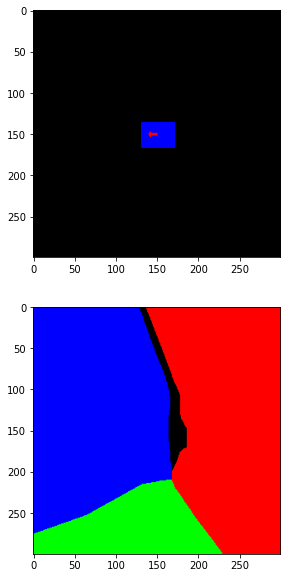

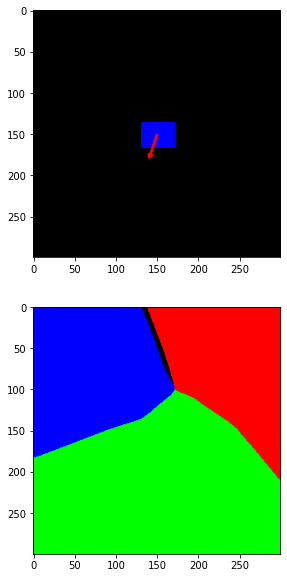

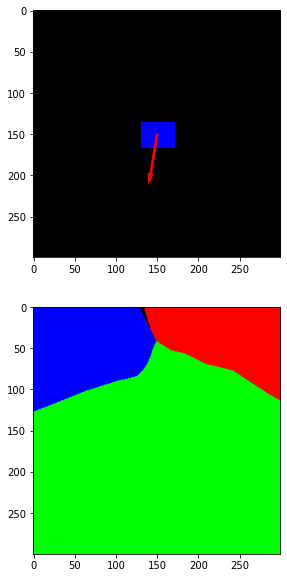

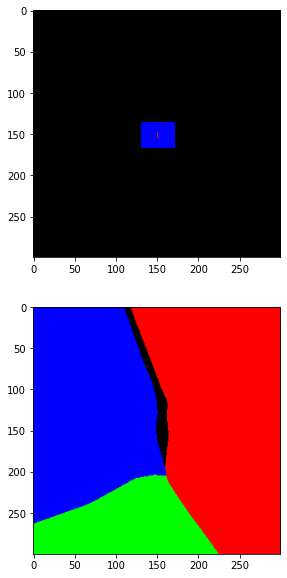

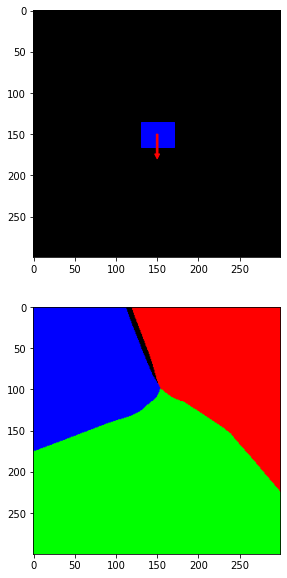

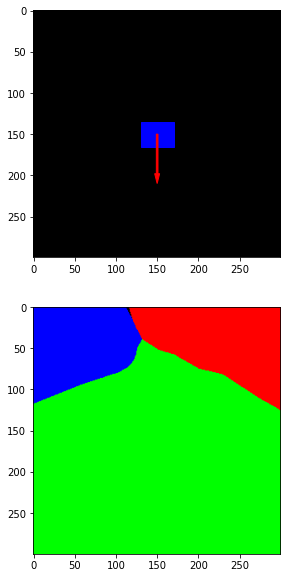

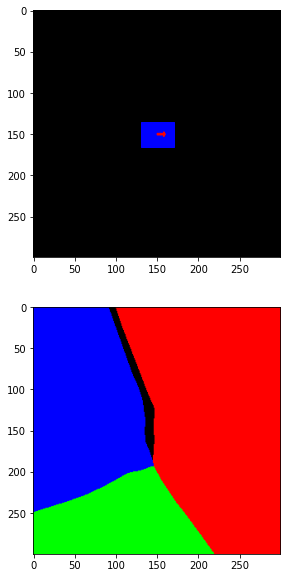

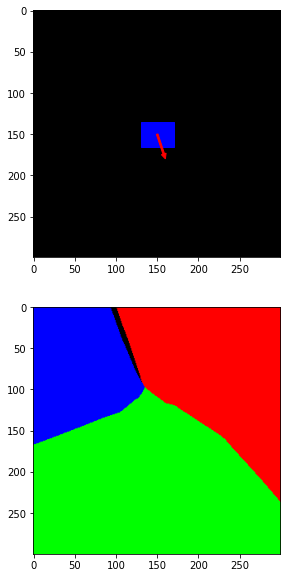

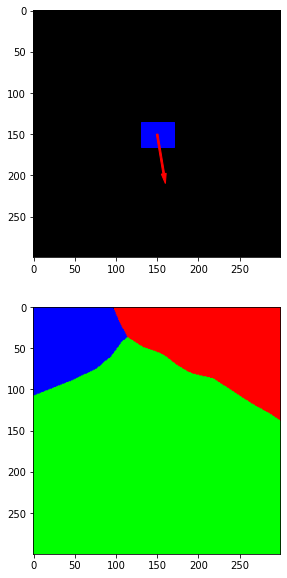

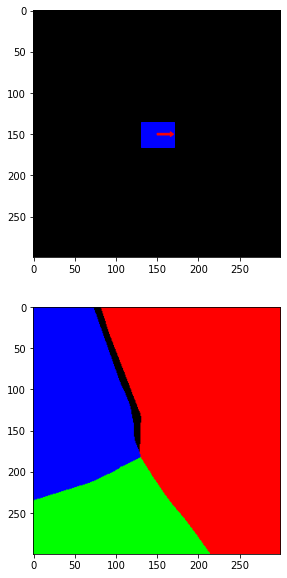

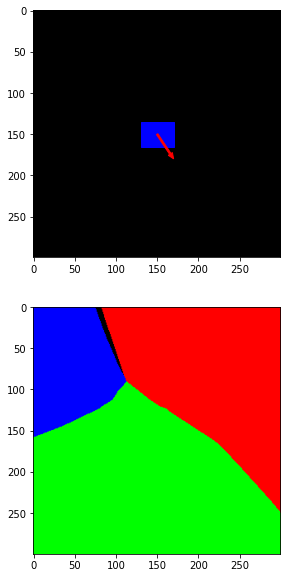

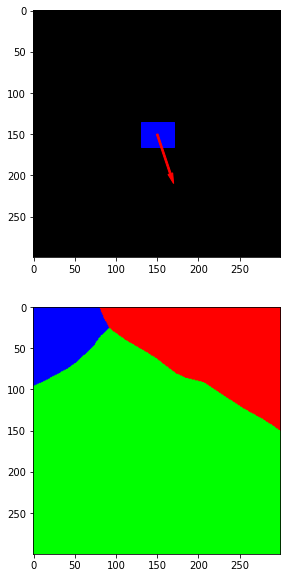

In [361]:
vx = [-0.2, -0.1, 0, 0.1 , 0.2]
vy = [0, -0.3, -0.6]
f = [0]
for i in range(5):
    for j in range(3):
        for k in range(1):
            picc(vx[i],vy[j],f[k])